In [81]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

import os
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [82]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [90]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'Z5BSBX52DHC3Z55TIOGLOYVXNHH5E2HSLLE4OILPV03NZB02'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='NUNENMWBYIAH4P5RIBM3XLZYPE0TWSYC51AYMTTOZNH3ESXX' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [84]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'FM32E0UU4KR1WU4VZIG1F5G1J2XFMKEGNF52UGPTSQ1J1CF1'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='R5SUZ4FBHNDVUMHP15ZKFIKI5VCQBLGPYSFGZY2LYQXMILX2' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [85]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [86]:
# get new york data
new_york_data=get_new_york_data()

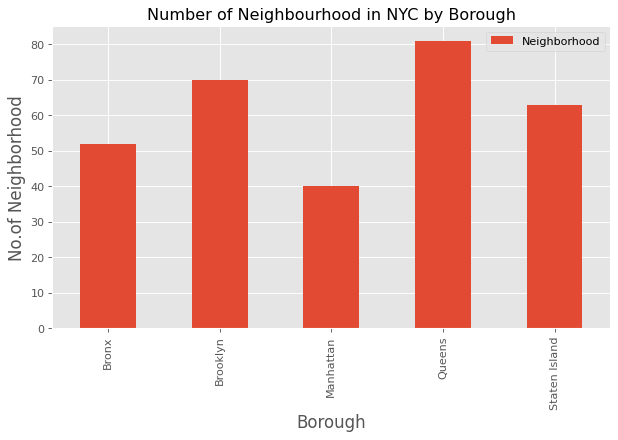

In [88]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

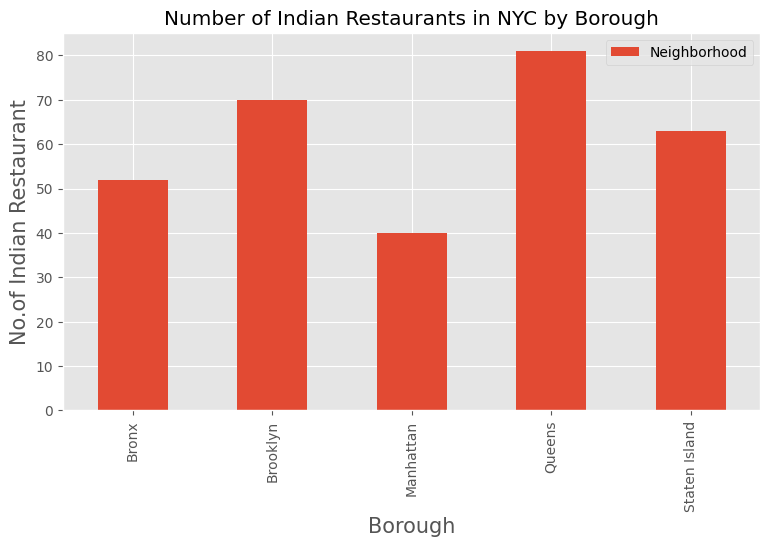

In [118]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurant', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [106]:
ind=new_york_data[new_york_data['Borough']=='Queens']

In [107]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [108]:
# type your answer here

manhattan_venues = getNearbyVenues(names=ind['Neighborhood'],
                                   latitudes=ind['Latitude'],
                                   longitudes=ind['Longitude']
                                  )



Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


In [122]:
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Astoria,40.768509,-73.915654,Simply Fit Astoria,40.769114,-73.912403,Gym
3,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
4,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym


In [123]:
rind=manhattan_venues[manhattan_venues['Venue Category'].str.contains("Restaurant")]

In [124]:
rind.shape

(561, 7)

In [126]:
# one hot encoding
manhattan_onehot = pd.get_dummies(rind[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = rind['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head(20)

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Astoria,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [127]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Arverne,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.500000,0.00,0.00000,0.000000,0.000000
1,Astoria,0.000000,0.025641,0.000000,0.000000,0.000000,0.025641,0.025641,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.0000,0.000000,0.000000,0.000000,0.128205,0.000000,0.00000,0.000000,0.076923,0.000000,0.051282,0.051282,0.025641,0.000000,0.025641,0.000000,0.076923,0.051282,0.153846,0.025641,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.102564,0.000000,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.000,0.000000,0.025641,0.00,0.00000,0.025641,0.000000
2,Astoria Heights,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000
3,Auburndale,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.333333,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000
4,Bay Terrace,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.333333,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.00000,0.00000

In [140]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arverne----
                 venue  freq
0      Thai Restaurant   0.5
1           Restaurant   0.5
2    Afghan Restaurant   0.0
3  Romanian Restaurant   0.0
4    Kosher Restaurant   0.0


----Astoria----
                       venue  freq
0  Middle Eastern Restaurant  0.15
1           Greek Restaurant  0.13
2         Seafood Restaurant  0.10
3   Mediterranean Restaurant  0.08
4          Indian Restaurant  0.08


----Astoria Heights----
                       venue  freq
0         Italian Restaurant   1.0
1        Japanese Restaurant   0.0
2          Kosher Restaurant   0.0
3  Latin American Restaurant   0.0
4           Malay Restaurant   0.0


----Auburndale----
                  venue  freq
0    Italian Restaurant  0.33
1      Sushi Restaurant  0.17
2  Fast Food Restaurant  0.17
3     Korean Restaurant  0.17
4   American Restaurant  0.17


----Bay Terrace----
                       venue  freq
0        American Restaurant  0.67
1     Gluten-free Restaurant  0.33
2        Romanian 

In [141]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [142]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Restaurant,Thai Restaurant,Vietnamese Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
1,Astoria,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Latin American Restaurant
2,Astoria Heights,Italian Restaurant,Indonesian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
3,Auburndale,Italian Restaurant,American Restaurant,Korean Restaurant,Sushi Restaurant,Fast Food Restaurant,Eastern European Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant
4,Bay Terrace,American Restaurant,Gluten-free Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant,French Restaurant


In [154]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5
bb= manhattan_grouped['Neighborhood']
manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)
#manhattan_grouped_clustering = manhattan_grouped
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 1, 1, 1, 4, 1, 1, 1], dtype=int32)

In [163]:
neighborhoods_venues_sorted['Cluster']=kmeans.labels_

In [157]:
manhattan_grouped_clustering=pd.concat([bb,manhattan_grouped_clustering],axis=1)
manhattan_grouped_clustering.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Cluster
0,Arverne,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.500000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.500000,0.0,0.0,0.000000,0.0,0
1,Astoria,0.0,0.025641,0.0,0.0,0.0,0.025641,0.025641,0.0,0.0,0.0,0.0,0.025641,0.0,0.0,0.0,0.0,0.0,0.0,0.025641,0.000000,0.0,0.0,0.0,0.000000,0.128205,0.0,0.0,0.0,0.076923,0.0,0.051282,0.051282,0.025641,0.0,0.025641,0.0,0.076923,0.051282,0.153846,0.025641,0.0,0.0,0.0,0.0,0.025641,0.0,0.102564,0.0,0.0,0.0,0.0,0.0,0.025641,0.0,0.0,0.0,0.025641,0.0,0.0,0.025641,0.0,1
2,Astoria Heights,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1
3,Auburndale,0.0,0.166667,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.166667,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.333333,0.000000,0.166667,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1
4,Bay Terrace,0.0,0.666667,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1


In [164]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = rind

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Latin American Restaurant,1
5,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Latin American Restaurant,1
6,Astoria,40.768509,-73.915654,Al-sham Sweets and Pastries,40.768077,-73.911561,Middle Eastern Restaurant,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Latin American Restaurant,1
9,Astoria,40.768509,-73.915654,The Gully,40.766719,-73.912410,Indian Restaurant,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Latin American Restaurant,1
11,Astoria,40.768509,-73.915654,Sabry's,40.768446,-73.911267,Seafood Restaurant,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Latin American Restaurant,1


In [166]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Neighborhood Latitude'], manhattan_merged['Neighborhood Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [177]:
manhattan_merged.loc[manhattan_merged['Cluster'] == 0, manhattan_merged.columns[[0] + list(range(5, manhattan_merged.shape[1]))]]     

,Neighborhood,Venue Longitude,Venue Category,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
1220,South Jamaica,-73.792267,Vegetarian / Vegan Restaurant,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Chinese Restaurant,Egyptian Restaurant,Indian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,0
1222,South Jamaica,-73.793022,Caribbean Restaurant,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Chinese Restaurant,Egyptian Restaurant,Indian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,0
1224,South Jamaica,-73.789948,Chinese Restaurant,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Chinese Restaurant,Egyptian Restaurant,Indian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,0
1230,St. Albans,-73.761234,Caribbean Restaurant,Caribbean Restaurant,Fast Food Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Vietnamese Restaurant,Empanada Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,Eastern European Restaurant,0
1232,St. Albans,-73.753546,Caribbean Restaurant,Caribbean Restaurant,Fast Food Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Vietnamese Restaurant,Empanada Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,Eastern European Restaurant,0
1234,St. Albans,-73.762452,Caribbean Restaurant,Caribbean Restaurant,Fast Food Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Vietnamese Restaurant,Empanada Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,Eastern European Restaurant,0
1238,St. Albans,-73.757082,Fast Food Restaurant,Caribbean Restaurant,Fast Food Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Vietnamese Restaurant,Empanada Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,Eastern European Restaurant,0
1240,St. Albans,-73.755528,Chinese Restaurant,Caribbean Restaurant,Fast Food Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Vietnamese Restaurant,Empanada Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,Eastern European Restaurant,0
1241,St. Albans,-73.761642,Caribbean Restaurant,Caribbean Restaurant,Fast Food Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Vietnamese Restaurant,Empanada Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,Eastern European Restaurant,0
1244,St. Albans,-73.762013,Southern / Soul Food Restaurant,Caribbean Restaurant,Fast Food Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Vietnamese Restaurant,Empanada Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,Eastern European Restaurant,0


In [178]:
manhattan_merged.loc[manhattan_merged['Cluster'] == 1, manhattan_merged.columns[[0] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Venue Longitude,Venue Category,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
0,Astoria,-73.917897,Brazilian Restaurant,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Latin American Restaurant,1
5,Astoria,-73.918104,Seafood Restaurant,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Latin American Restaurant,1
6,Astoria,-73.911561,Middle Eastern Restaurant,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Latin American Restaurant,1
9,Astoria,-73.912410,Indian Restaurant,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Latin American Restaurant,1
11,Astoria,-73.911267,Seafood Restaurant,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Latin American Restaurant,1
12,Astoria,-73.912713,Restaurant,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Latin American Restaurant,1
13,Astoria,-73.911013,Falafel Restaurant,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Latin American Restaurant,1
14,Astoria,-73.911169,Seafood Restaurant,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Latin American Restaurant,1
15,Astoria,-73.918530,Greek Restaurant,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Latin American Restaurant,1
17,Astoria,-73.918214,Mexican Restaurant,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Latin American Restaurant,1


In [179]:
manhattan_merged.loc[manhattan_merged['Cluster'] == 2, manhattan_merged.columns[[0] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Venue Longitude,Venue Category,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
820,South Ozone Park,-73.810611,Fast Food Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Indonesian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,2
2037,Roxbury,-73.891848,Fast Food Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Indonesian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,2
2067,Hammels,-73.809752,Fast Food Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Indonesian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,2


In [180]:
manhattan_merged.loc[manhattan_merged['Cluster'] == 3, manhattan_merged.columns[[0] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Venue Longitude,Venue Category,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
1113,Briarwood,-73.807214,Indian Restaurant,Indian Restaurant,Indonesian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,3
1565,Floral Park,-73.708540,Indian Restaurant,Indian Restaurant,Indonesian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,3
1568,Floral Park,-73.709756,Indian Restaurant,Indian Restaurant,Indonesian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,3
1569,Floral Park,-73.710076,Indian Restaurant,Indian Restaurant,Indonesian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,3
1578,Jamaica Estates,-73.786781,Indian Restaurant,Indian Restaurant,Indonesian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,3


In [181]:
manhattan_merged.loc[manhattan_merged['Cluster'] == 4, manhattan_merged.columns[[0] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Venue Longitude,Venue Category,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
643,Maspeth,-73.898659,Sushi Restaurant,Chinese Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Eastern European Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,4
644,Maspeth,-73.894270,Italian Restaurant,Chinese Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Eastern European Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,4
647,Maspeth,-73.892359,Japanese Restaurant,Chinese Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Eastern European Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,4
664,Maspeth,-73.892708,Chinese Restaurant,Chinese Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Eastern European Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,4
665,Maspeth,-73.891766,Chinese Restaurant,Chinese Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Eastern European Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,4
668,Maspeth,-73.892946,Chinese Restaurant,Chinese Restaurant,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Eastern European Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,4
1097,Fresh Meadows,-73.783293,Vegetarian / Vegan Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,4
1098,Fresh Meadows,-73.783484,Chinese Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,4
1106,Fresh Meadows,-73.778004,Chinese Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,4
1213,Hollis,-73.764411,Chinese Restaurant,Asian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Himalayan Restaurant,Halal Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,4


---
# Recommended Neighbourhood to open a new Indian Restaurant- Briarwood, Floral Park and Jamaica Estates.


